# Impact calculations with data from OpenStreetMap
## Paper Sketch openstreetmap & lines_polys_handler modules

In [264]:
import matplotlib.pyplot as plt
import shapely
import contextily as ctx
from pathlib import Path
from datetime import datetime
import numpy as np
import pandas as pd

from climada.util.api_client import Client
import climada.util.lines_polys_handler as u_lp
from climada.engine.impact_calc import ImpactCalc
from climada.entity.impact_funcs import ImpactFuncSet, ImpactFunc
from climada.entity.impact_funcs.storm_europe import ImpfStormEurope
from climada.entity import Exposures
from climada.entity import LitPop
from climada import CONFIG

from climada_petals.entity.exposures.openstreetmap.osm_dataloader import OSMRaw, OSMFileQuery
from climada_petals.entity.exposures.openstreetmap.osm_dataloader import DICT_CIS_OSM

### Getting OSM Files

In [2]:
# download osm.pbf file for Switzerland from geofabrik
DATA_DIR = CONFIG.exposures.openstreetmap.local_data.dir()
OSMRaw().get_data_geofabrik('CHE', file_format='pbf', save_path=DATA_DIR)

2023-03-21 11:13:29,602 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - file already exists as /Users/evelynm/climada/data/openstreetmap/switzerland-latest.osm.pbf


### Extracting geo-data from OSM files

In [8]:
DICT_CIS_OSM.keys()

dict_keys(['education', 'healthcare', 'water', 'telecom', 'road', 'main_road', 'rail', 'air', 'gas', 'oil', 'power', 'wastewater', 'food', 'buildings'])

In [265]:
# Initiate a OSMFileQuery instance with path to the downloaded file
SwissFileQuery = OSMFileQuery(Path(DATA_DIR,'switzerland-latest.osm.pbf'))

## Healthcare infrastructure

In [181]:
gdf_health = SwissFileQuery.retrieve_cis('healthcare')

2023-03-21 12:59:38,489 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1926/1926 [00:23<00:00, 82.23it/s]

2023-03-21 13:00:25,650 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1403/1403 [01:04<00:00, 21.92it/s]
/Users/evelynm/climada_petals/climada_petals/entity/exposures/openstreetmap/osm_dataloader.py:560: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  gdf = gdf.append(


In [117]:
# Pre-processing: duplicate entry removal

In [180]:
def _find_duplicates(overlap_gdf):
    indices_dupl = np.unique([index_right for index_right, index_left in zip(overlap_gdf.index_right, overlap_gdf.index_left)
                    if index_right != index_left])
    indices_dupl = indices_dupl[:int(len(indices_dupl/2))] # only first half of duplicates should be removed!
    return indices_dupl

def _remove_duplicates(orig_gdf, indices_dupl):
    indices_keep = list(set(orig_gdf.index).difference(set(indices_dupl)))
    return orig_gdf.loc[indices_keep]

def find_remove_duplicates(orig_gdf):
    if 'index' in orig_gdf.columns:
        orig_gdf = orig_gdf.drop('index', axis=1)
    overlap_gdf = orig_gdf.sjoin(orig_gdf)
    if 'index_left' not in overlap_gdf.columns:
        overlap_gdf = overlap_gdf.reset_index()
        overlap_gdf = overlap_gdf.rename({'index':'index_left'}, axis=1)  
    indices_dupl = _find_duplicates(overlap_gdf)
    return _remove_duplicates(orig_gdf, indices_dupl)   

In [182]:
gdf_health = gdf_health.reset_index(drop=True)
gdf_health_pnt = gdf_health[gdf_health.geometry.type=='Point']
gdf_health_pnt['geometry'] = gdf_health_pnt.geometry.buffer(0.001) # ca. 100m buffer
gdf_health_poly = gdf_health[gdf_health.geometry.type=='MultiPolygon']

In [183]:
gdf_health_pnt = find_remove_duplicates(gdf_health_pnt)
gdf_health_poly = find_remove_duplicates(gdf_health_poly)

In [184]:
gdf_health = pd.concat([gdf_health_pnt, gdf_health_poly])
gdf_health = find_remove_duplicates(gdf_health)
gdf_health['geometry'] = gdf_health.geometry.centroid

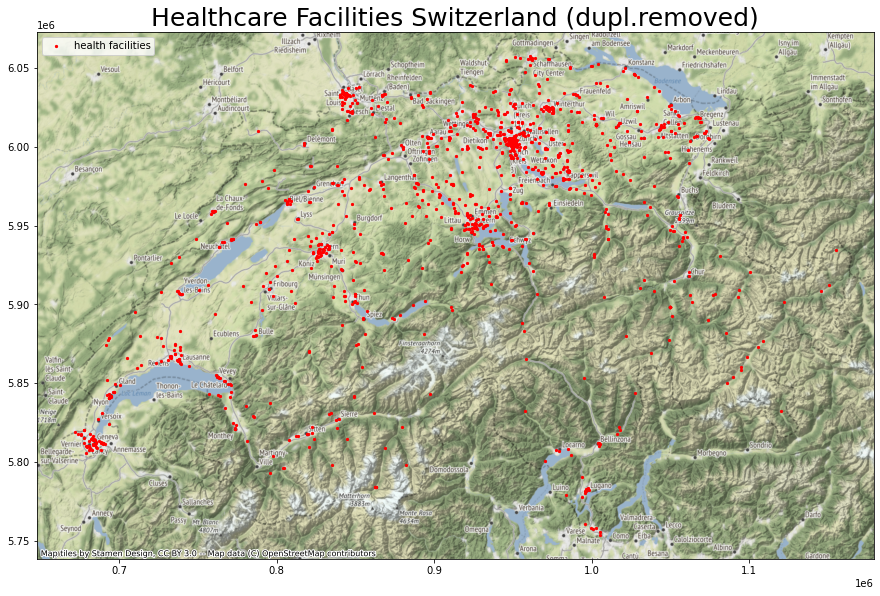

In [190]:
ax = gdf_health.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='red', 
                    edgecolor='red', label='health facilities')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Healthcare Facilities Switzerland (dupl.removed)', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Education, or Airports (or similar)

In [135]:
gdf_airports_orig = SwissFileQuery.retrieve_cis('air')

2023-03-21 12:41:02,854 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:39<00:00,  2.62s/it]


In [173]:
# pre-processing: duplicate entry removal
import copy
gdf_airports = copy.deepcopy(gdf_airports_orig.reset_index(drop=True))
gdf_airports_pnt = gdf_airports[gdf_airports.geometry.type=='Point']
gdf_airports_pnt['geometry'] = gdf_airports_pnt.geometry.buffer(0.001) # ca. 100m buffer
gdf_airports_poly = gdf_airports[gdf_airports.geometry.type=='MultiPolygon']

In [174]:
gdf_airports_poly = find_remove_duplicates(gdf_airports_poly)
gdf_airports_pnt = find_remove_duplicates(gdf_airports_pnt)

In [176]:
gdf_airports = pd.concat([gdf_airports_pnt, gdf_airports_poly])
gdf_airports = find_remove_duplicates(gdf_airports)
gdf_airports['geometry'] = gdf_airports.geometry.centroid

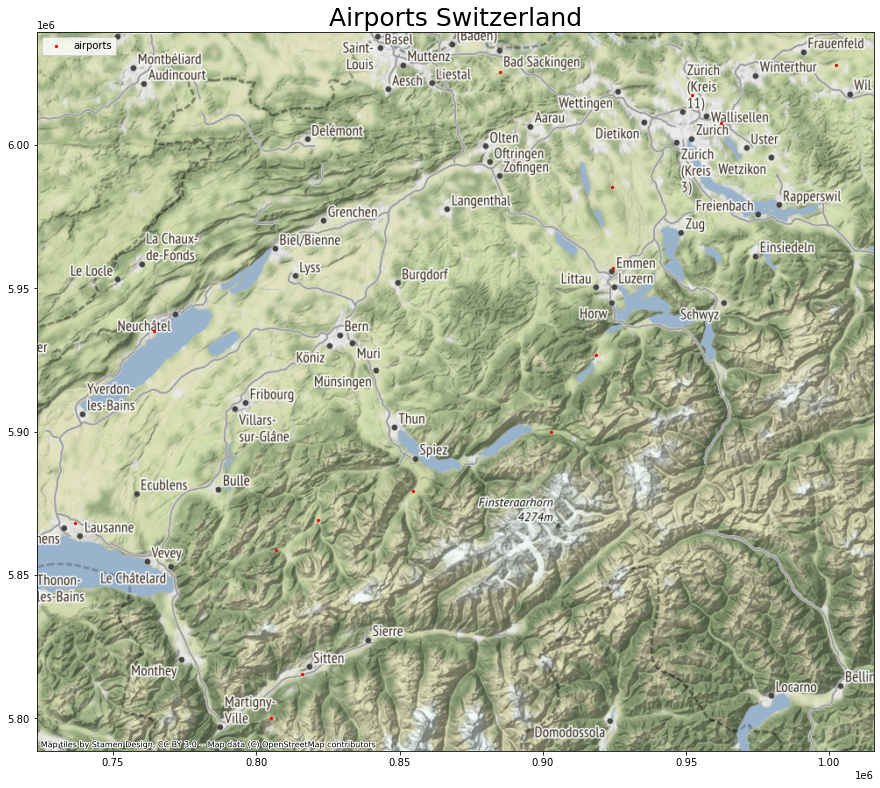

In [192]:
# plot results
ax = gdf_airports.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='brown', 
                    edgecolor='red', label='airports')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Airports Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Railways

In [208]:
osm_keys=['railway', 'name']
osm_query="railway='rail' or railway='tram' or railway='light_rail' or railway='narrow_gauge'"

gdf_rails = SwissFileQuery.retrieve('lines', osm_keys, osm_query)

2023-03-21 14:24:46,217 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract lines: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50514/50514 [00:20<00:00, 2427.95it/s]


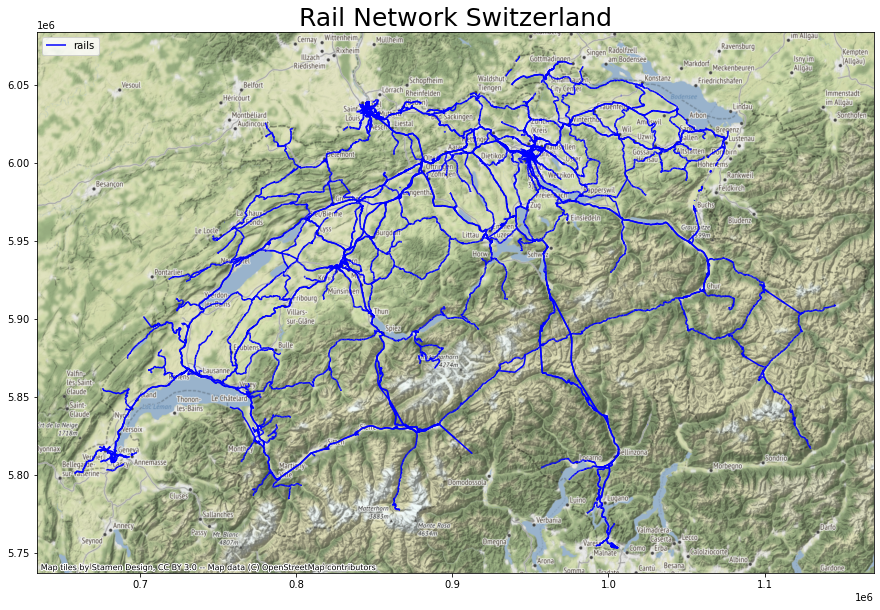

In [7]:
# plot results
ax = gdf_rails.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='blue', 
                    edgecolor='blue', label='rails')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Rail Network Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

## Forests 

In [193]:
# Forests in Switzerland
osm_keys = ['landuse']
osm_query = "landuse='forest'"
gdf_forest = SwissFileQuery.retrieve('multipolygons', osm_keys, osm_query)

2023-03-21 14:20:52,727 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract multipolygons: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 76090/76090 [00:49<00:00, 1552.43it/s]


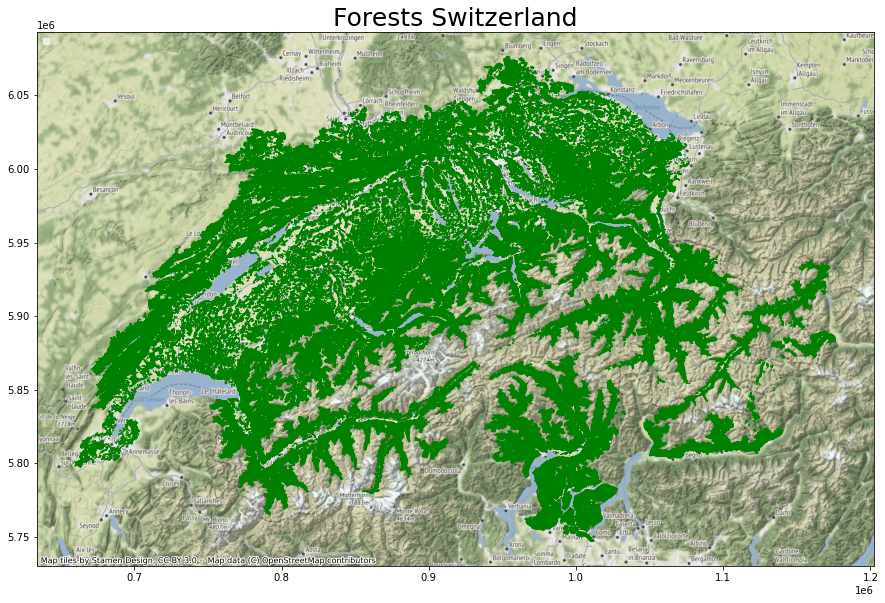

In [194]:
# plot results
ax = gdf_forest.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=5, color='green', 
                    edgecolor='green', label='forest')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('Forests Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

In [195]:
# do some cleaning: only valid shapes, not very tiny ones
import shapely
def make_valid(geometry):
    if geometry.is_valid:
        return geometry
    return geometry.buffer(0.0001)

In [196]:
gdf_forest['geometry'] = gdf_forest.apply(lambda row: make_valid(row.geometry), axis=1)
gdf_forest = gdf_forest[gdf_forest['geometry'].area > 1e-5]

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1981: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  numbe

In [ ]:
# consumes too much memory
# shapely.ops.unary_union(gdf_forest.geometry)
# shapely.ops.unary_union(gdf_forest['geometry'][gdf_forest['geometry'].type=='MultiPolygon'])

## UNESCO Cultural Heritage Sites

In [266]:
unesco_query = {
    'osm_keys': ['heritage_operator', 'name', 'heritage'],
    'osm_query': "heritage_operator='whc'"
}

In [267]:
gdf_list = []
for shape in ['points', 'lines', 'multipolygons']:
    try:
        gdf = SwissFileQuery.retrieve(shape, unesco_query['osm_keys'], unesco_query['osm_query'])
        gdf_list.append(gdf)
    except TypeError:
        print(f'{shape} not found')
gdf_unesco = pd.concat(gdf_list)
gdf_unesco

2023-03-21 15:27:37,260 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop


extract points: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:06<00:00,  1.17it/s]

2023-03-21 15:27:51,369 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract lines: 0it [00:10, ?it/s]

2023-03-21 15:28:14,161 - climada_petals.entity.exposures.openstreetmap.osm_dataloader - INFO - query is finished, lets start the loop



extract multipolygons: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:57<00:00, 19.17s/it]


osm_id heritage_operator                          name heritage  \
0    26863957               whc             Monte San Giorgio        1   
1  1453589407               whc          Morges - Les Roseaux        1   
2  1453589408               whc   Morges - Stations de Morges        1   
3  2194901120               whc                      Altstadt        1   
4  2195309046               whc  UNESCO-Welterbe - Lobsigesee        1   
5  3256406527               whc                  Castelgrande        1   
6  3256443027               whc        Castello di Montebello        1   
7  3256443038               whc     Castello di Sasso Corbaro        1   
0        None               whc                  Stiftsbezirk        1   
1        None               whc                  Stiftskirche        1   
2        None               whc                      Lochsite     None   

                                            geometry  
0                           POINT (8.94989 45.91376)  
1                           POINT (6.50810 46.51484)  
2                           POINT (6.50258 46.50943)  
3                           POINT (7.45127 46.94829)  
4                           POINT (7.29772 47.03162)  
5                           POINT (9.02175 46.19290)  
6                           POINT (9.02657 46.19129)  
7                           POINT (9.03013 46.18812)  
0  MULTIPOLYGON (((9.37641 47.42251, 9.37605 47.4...  
1  MULTIPOLYGON (((9.37747 47.42317, 9.37722 47.4...  
2  MULTIPOLYGON (((9.09276 46.99676, 9.09237 46.9...

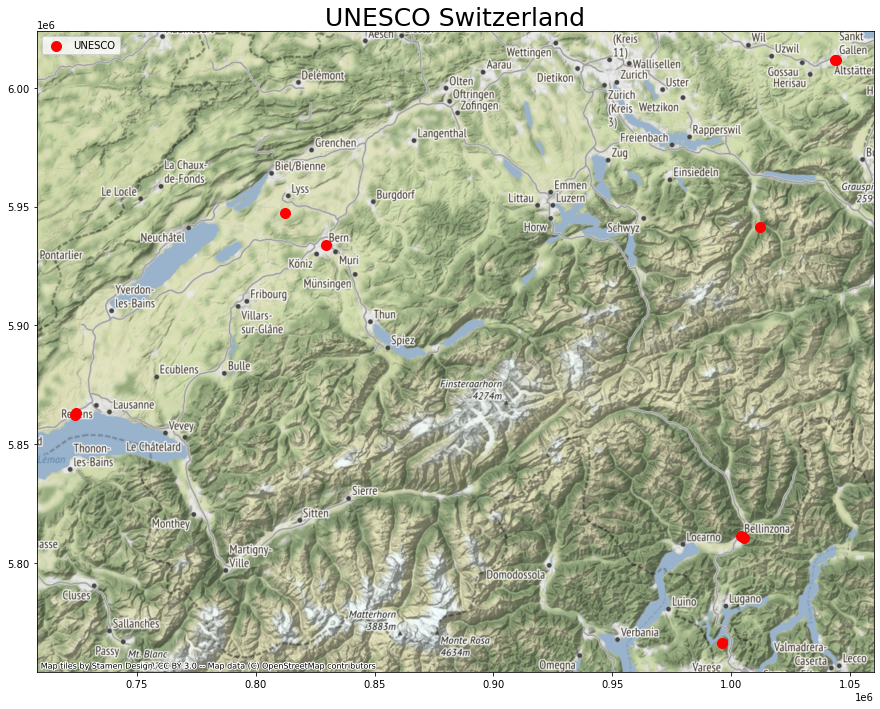

In [269]:
# plot results
gdf_unesco_plot = gdf_unesco.copy()
gdf_unesco_plot.geometry = gdf_unesco_plot.geometry.centroid
ax = gdf_unesco_plot.set_crs(epsg=4326).to_crs(epsg=3857).plot(figsize=(15, 15), alpha=1, markersize=100, color='red', 
                    edgecolor='red', label='UNESCO')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles, loc='upper left')
ax.set_title('UNESCO Switzerland', fontsize=25)
ctx.add_basemap(ax)
plt.show()

### Loading Hazard Data

In [197]:
# Let's take european winter storms
client = Client()
ws_che = client.get_hazard('storm_europe', properties={'country_name': 'Switzerland'})
ws_che = ws_che.select(orig=True)

2023-03-21 14:24:20,680 - climada.hazard.base - INFO - Reading /Users/evelynm/climada/data/hazard/storm_europe/storm_europe_150arcsec_CHE/v1/WISC_prob_CHE.hdf5


In [58]:
#print(datetime.fromordinal(int(np.min(ws_che.date))))
#print(datetime.fromordinal(int(np.max(ws_che.date))))

1940-11-01 00:00:00
2013-12-05 00:00:00


In [198]:
# Lothar happened around Dec 26, 1999
date_lothar_start = datetime(1999, 12, 25)
date_lothar_end = datetime(1999, 12, 31)

date_lothar_start_ordinal = date_lothar_start.toordinal()
date_lothar_end_ordinal = date_lothar_end.toordinal()

In [199]:
ws_lothar = ws_che.select(date=[date_lothar_start_ordinal, date_lothar_end_ordinal])

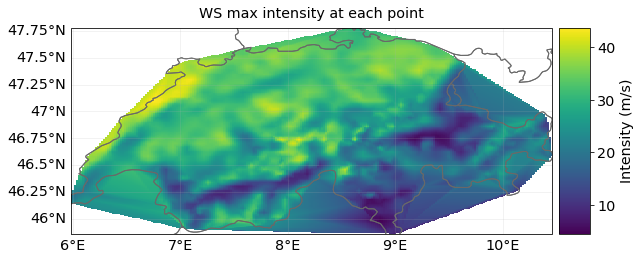

In [240]:
ws_lothar.plot_intensity(0)
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_lothar.frequency = np.array([1])

In [61]:
# Vivian happened around Feb 27, 1990
date_vivian_start = datetime(1990, 2, 26)
date_vivian_end = datetime(1990, 2, 28)

date_vivian_start_ordinal = date_vivian_start.toordinal()
date_vivian_end_ordinal = date_vivian_end.toordinal()

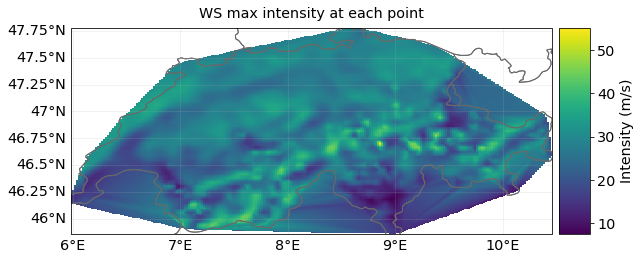

In [62]:
ws_vivian = ws_che.select(date=[date_vivian_start_ordinal, date_vivian_end_ordinal])
ws_vivian.plot_intensity(0)
# ugly work-around for making eai_exp plot an at_event plot later --> frequency = 1
ws_vivian.frequency = np.array([1])

### Impact Calculations for Line & Polygon data

### Defining impact functions

In [201]:
impf_set = ImpactFuncSet()

<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>

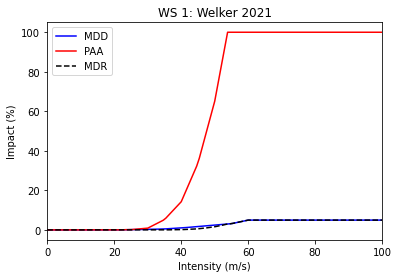

In [202]:
impf_set.append(ImpfStormEurope.from_welker())
impf_set.check()
impf_set.plot()

array([<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
      dtype=object)

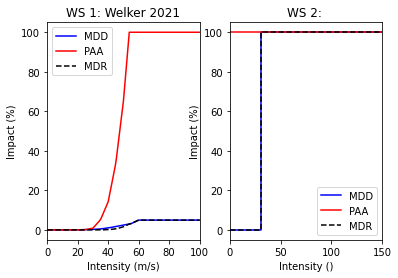

In [203]:
impf_thresh = ImpactFunc.from_step_impf([0,30.5,150],impf_id=2) # start of warning level 4 MCH
impf_thresh.haz_type = 'WS'
impf_set.append(impf_thresh)
impf_set.check()
impf_set.plot()

array([<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
       <AxesSubplot:title={'center':'WS 3: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
      dtype=object)

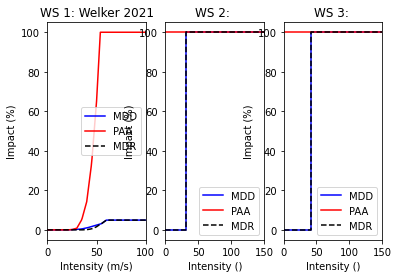

In [204]:
impf_threeblow = ImpactFunc.from_step_impf([0,42,150],impf_id=3) # tree blowdown fund
impf_threeblow.haz_type = 'WS'
impf_set.append(impf_threeblow)
impf_set.check()
impf_set.plot()

array([[<AxesSubplot:title={'center':'WS 1: Welker 2021'}, xlabel='Intensity (m/s)', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'WS 2: '}, xlabel='Intensity ()', ylabel='Impact (%)'>],
       [<AxesSubplot:title={'center':'WS 3: '}, xlabel='Intensity ()', ylabel='Impact (%)'>,
        <AxesSubplot:title={'center':'WS 4: '}, xlabel='Intensity ()', ylabel='Impact (%)'>]],
      dtype=object)

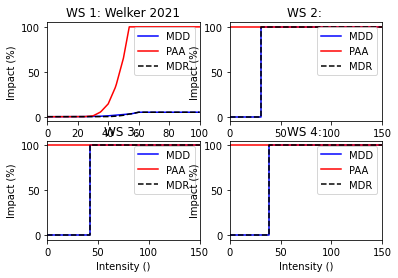

In [257]:
impf_W5 = ImpactFunc.from_step_impf([0,38.9,150],impf_id=4) # tree blowdown fund
impf_W5.haz_type = 'WS'
impf_set.append(impf_W5)
impf_set.check()
impf_set.plot()

### Exposures from gdfs

In [205]:
exp_health = Exposures(gdf_health)
exp_health.gdf['impf_WS'] = 2
exp_health.gdf['value'] = 1
exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points
exp_health.set_lat_lon()
exp_health.check()

2023-03-21 14:24:24,607 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:24:24,642 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 14:24:24,642 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 14:24:24,643 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 14:24:24,644 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 14:24:24,645 - climada.entity.exposures.base - INFO - centr_ not set.


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_47635/3092231282.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_health.gdf['geometry'] = exp_health.gdf.geometry.centroid # simplify to points


In [223]:
exp_airports = Exposures(gdf_airports)
exp_airports.gdf['impf_WS'] = 2
exp_airports.gdf['value'] = 1
exp_airports.set_lat_lon()
exp_airports.check()

2023-03-21 14:27:34,540 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:27:34,548 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 14:27:34,549 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 14:27:34,550 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 14:27:34,551 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 14:27:34,552 - climada.entity.exposures.base - INFO - centr_ not set.


In [210]:
# Making exposures with non-point geometry data:
exp_rails = Exposures(gdf_rails)
exp_rails.gdf['impf_WS'] = 2

In [251]:
gdf_forest_42 = copy.deepcopy(gdf_forest)
exp_forest_42 = Exposures(gdf_forest_42)
exp_forest_42.gdf['impf_WS'] = 3

In [252]:
gdf_forest_W4 = copy.deepcopy(gdf_forest)
exp_forest_W4 = Exposures(gdf_forest_W4)
exp_forest_W4.gdf['impf_WS'] = 2

In [258]:
gdf_forest_W5 = copy.deepcopy(gdf_forest)
exp_forest_W5 = Exposures(gdf_forest_W5)
exp_forest_W5.gdf['impf_WS'] = 4

In [219]:
# Making exposures with non-point geometry data:
exp_airport = Exposures(gdf_airports)
exp_airport.gdf['impf_WS'] = 2

In [270]:
# UNESCO heritage sites
exp_unesco = Exposures(gdf_unesco)
exp_unesco.gdf['impf_WS'] = 2
exp_unesco.gdf['value'] = 1
exp_unesco.gdf['geometry'] = exp_unesco.gdf.geometry.centroid # simplify to points
exp_unesco.set_lat_lon()
exp_unesco.check()

2023-03-21 15:31:20,142 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 15:31:20,146 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 15:31:20,147 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 15:31:20,148 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 15:31:20,149 - climada.entity.exposures.base - INFO - region_id not set.
2023-03-21 15:31:20,150 - climada.entity.exposures.base - INFO - centr_ not set.


/var/folders/jm/4przql117d9gb9g4hb45fd4c0000gp/T/ipykernel_47635/1907033712.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  exp_unesco.gdf['geometry'] = exp_unesco.gdf.geometry.centroid # simplify to points


### Exposures from LitPop

In [305]:
# asset values (1,1)
exp_lp = LitPop().from_countries(['CHE'],reference_year=1999)
exp_lp.gdf['impf_WS'] = 1

2023-03-21 16:37:45,991 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-03-21 16:37:46,387 - climada.entity.exposures.litpop.nightlight - INFO - No satellite files found locally in /Users/evelynm/climada/data
2023-03-21 16:37:46,388 - climada.entity.exposures.litpop.nightlight - INFO - Attempting to download file from https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144897/BlackMarble_2012_C1_geo_gray.tif
2023-03-21 16:37:46,946 - climada.entity.exposures.litpop.nightlight - INFO - Attempting to download file from https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144896/BlackMarble_2012_C1_geo_gray.tif
2023-03-21 16:37:47,426 - climada.util.files_handler - INFO - Downloading https://eoimages.gsfc.nasa.gov/images/imagerecords/144000/144896/BlackMarble_2012_C1_geo_gray.tif to file /Users/evelynm/climada/data/BlackMarble_2012_C1_geo_gray.tif


45.7kKB [01:23, 550KB/s]                                                                                                                                                                                                                                                  


2023-03-21 16:39:16,584 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-21 16:39:16,585 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 16:39:16,585 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 16:39:16,586 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 16:39:16,587 - climada.entity.exposures.base - INFO - centr_ not set.


In [306]:
# population gridded counts (0,1)
exp_pop = LitPop().from_countries(['CHE'], exponents=(0, 1), fin_mode='pop', reference_year=1999)
exp_pop.gdf['impf_WS'] = 2

2023-03-21 16:39:17,122 - climada.entity.exposures.litpop.litpop - INFO - 
 LitPop: Init Exposure for country: CHE (756)...

2023-03-21 16:39:20,781 - climada.entity.exposures.base - INFO - Hazard type not set in impf_
2023-03-21 16:39:20,783 - climada.entity.exposures.base - INFO - category_id not set.
2023-03-21 16:39:20,784 - climada.entity.exposures.base - INFO - cover not set.
2023-03-21 16:39:20,784 - climada.entity.exposures.base - INFO - deductible not set.
2023-03-21 16:39:20,785 - climada.entity.exposures.base - INFO - centr_ not set.


### Impact calculations

2023-03-21 14:25:54,422 - climada.entity.exposures.base - INFO - Matching 1155 exposures with 3057 centroids.
2023-03-21 14:25:54,424 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:25:54,434 - climada.engine.impact_calc - INFO - Calculating impact for 3465 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

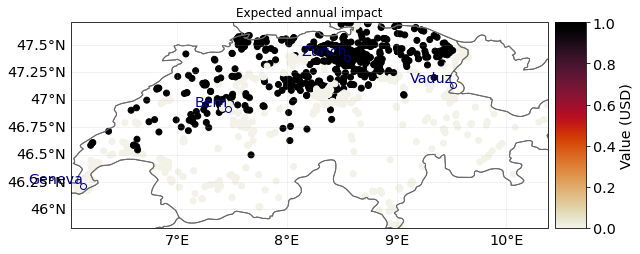

In [216]:
# Healthcare facilities
imp_health = ImpactCalc(exp_health, impf_set, ws_lothar).impact()
imp_health.plot_scatter_eai_exposure()

2023-03-21 14:27:41,726 - climada.entity.exposures.base - INFO - Matching 15 exposures with 3057 centroids.
2023-03-21 14:27:41,730 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:27:41,737 - climada.engine.impact_calc - INFO - Calculating impact for 45 assets (>0) and 1 events.


' \nonly for polygon-based exposure\n# all-in-one calculation for lines: \n# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),\n# and re-aggregate the sum of damages to the original exposure format\n\nimp_airport = u_lp.calc_geom_impact(\n    exp=exp_airports, impf_set=impf_set, haz=ws_lothar,\n    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,\n    agg_met=u_lp.AggMethod.SUM)\n\n# plot the impacts\nu_lp.plot_eai_exp_geom(imp_airport)\n'

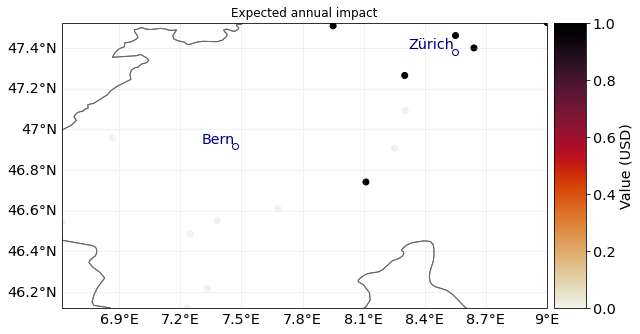

In [224]:
# Airports
imp_airport = ImpactCalc(exp_airports, impf_set, ws_lothar).impact()
imp_airport.plot_scatter_eai_exposure()

""" 
only for polygon-based exposure
# all-in-one calculation for lines: 
# interpolate to 500 m resolution, assign each point a fixed value of 500 (metres),
# and re-aggregate the sum of damages to the original exposure format

imp_airport = u_lp.calc_geom_impact(
    exp=exp_airports, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM)

# plot the impacts
u_lp.plot_eai_exp_geom(imp_airport)
"""

In [280]:
gdf_rails_proj = gdf_rails.to_crs('EPSG:2056')
gdf_rails_proj.geometry.length.sum()

12450052.771180911

In [293]:
gdf_rails = gdf_rails.set_crs('EPSG:4326')

In [294]:
gdf_rails_pnt = u_lp.gdf_to_pnts(gdf_rails, res=100, to_meters=True)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


2023-03-21 15:49:21,613 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 15:49:26,213 - climada.entity.exposures.base - INFO - Matching 202670 exposures with 3057 centroids.
2023-03-21 15:49:26,219 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 15:49:26,479 - climada.engine.impact_calc - INFO - Calculating impact for 608010 assets (>0) and 1 events.


<AxesSubplot:>

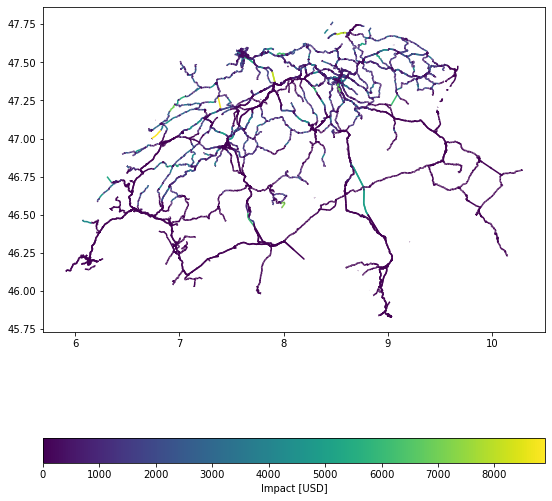

In [282]:
# railways

# all-in-one calculation for lines: 
# interpolate to 100 m resolution, assign each point a fixed value of 100 (metres),
# and re-aggregate the sum of damages to the original exposure format
imp_rails = u_lp.calc_geom_impact(
    exp=exp_rails, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100,
    agg_met=u_lp.AggMethod.SUM
)

# plot the impacts
u_lp.plot_eai_exp_geom(imp_rails)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 14:52:49,818 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:53:16,535 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 14:53:16,561 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:53:18,176 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

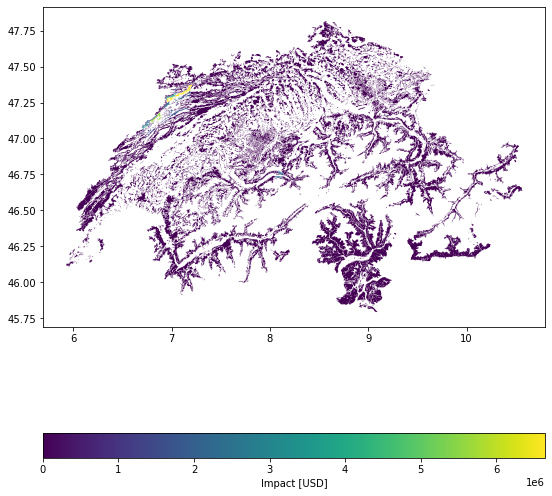

In [253]:
# Forest, with imp func 3 (>42)

imp_forest_42 = u_lp.calc_geom_impact(
    exp=exp_forest_42, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_42)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 14:41:22,741 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 14:41:49,033 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 14:41:49,060 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 14:41:50,524 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

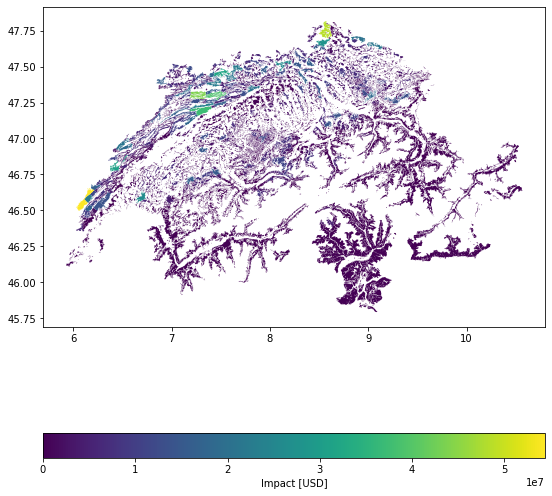

In [235]:
# Forest, with imp func 2 (>30.5)

imp_forest_W4 = u_lp.calc_geom_impact(
    exp=exp_forest_W4, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_W4)

/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:383: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  iter(obj)  # Can iterate over it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/inference.py:384: ShapelyDeprecationWarning: __len__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Check the length of the `geoms` property instead to get the  number of parts of a multi-part geometry.
  len(obj)  # Has a length associated with it.
/Users/evelynm/opt/anaconda3/envs/climada_env/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_a

2023-03-21 15:00:19,888 - climada.entity.exposures.base - INFO - Setting latitude and longitude attributes.
2023-03-21 15:00:48,246 - climada.entity.exposures.base - INFO - Matching 1255598 exposures with 3057 centroids.
2023-03-21 15:00:48,266 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 15:00:49,969 - climada.engine.impact_calc - INFO - Calculating impact for 3766794 assets (>0) and 1 events.


<AxesSubplot:>

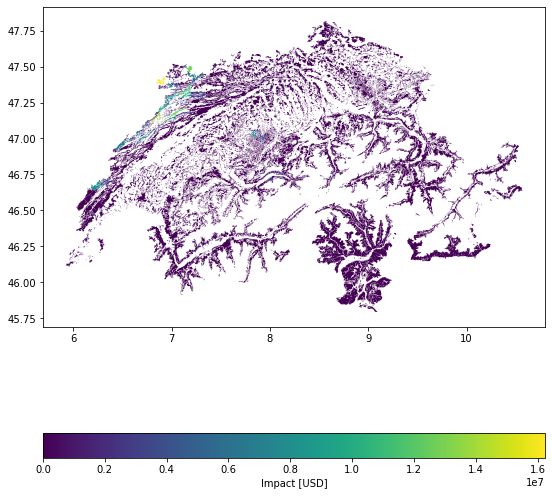

In [259]:
# Forest, with imp func 4 (>W5)

imp_forest_W5 = u_lp.calc_geom_impact(
    exp=exp_forest_W5, impf_set=impf_set, haz=ws_lothar,
    res=100, to_meters=True, disagg_met=u_lp.DisaggMethod.FIX, disagg_val=100*100,
    agg_met=u_lp.AggMethod.SUM
)

# plot results.
u_lp.plot_eai_exp_geom(imp_forest_W5)

2023-03-21 15:32:20,416 - climada.entity.exposures.base - INFO - Matching 11 exposures with 3057 centroids.
2023-03-21 15:32:20,419 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 15:32:20,425 - climada.engine.impact_calc - INFO - Calculating impact for 33 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

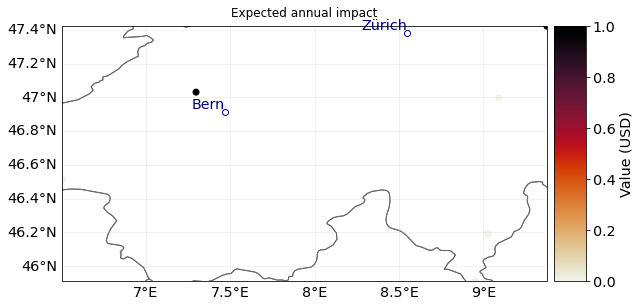

In [271]:
# Unesco heritage sites
imp_unesco = ImpactCalc(exp_unesco, impf_set, ws_lothar).impact()
imp_unesco.plot_scatter_eai_exposure()

2023-03-21 16:41:13,203 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-21 16:41:13,216 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 16:41:13,295 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

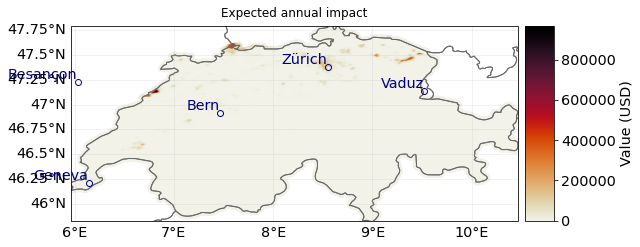

In [307]:
imp_lp = ImpactCalc(exp_lp, impf_set, ws_lothar).impact()
imp_lp.plot_scatter_eai_exposure()

2023-03-21 16:41:16,128 - climada.entity.exposures.base - INFO - Matching 70287 exposures with 3057 centroids.
2023-03-21 16:41:16,131 - climada.util.coordinates - INFO - No exact centroid match found. Reprojecting coordinates to nearest neighbor closer than the threshold = 100
2023-03-21 16:41:16,210 - climada.engine.impact_calc - INFO - Calculating impact for 204882 assets (>0) and 1 events.


<GeoAxesSubplot:title={'center':'Expected annual impact'}>

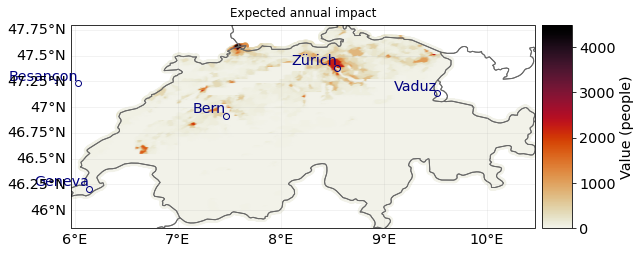

In [308]:
imp_pop = ImpactCalc(exp_pop, impf_set, ws_lothar).impact()
imp_pop.plot_scatter_eai_exposure()

### Summary table

In [309]:
summary_table = pd.DataFrame()
summary_table['exposure'] = ['Asset Values', 'Population', 'Healthcare Facilities', 'Airports','UNESCO world heritage sites',
                             'Railways', 'Forest Area (>W5)']
summary_table['event_impact'] = [imp.aai_agg for imp in [imp_lp, imp_pop, imp_health, imp_airport, imp_unesco,
                                                         imp_rails, imp_forest_W5]]
summary_table['metric'] = ['USD', 'people', 'units', 'units','units', 'm', 'm2']

In [310]:
summary_table

exposure  event_impact  metric
0                 Asset Values  1.794103e+08     USD
1                   Population  4.175326e+06  people
2        Healthcare Facilities  6.490000e+02   units
3                     Airports  6.000000e+00   units
4  UNESCO world heritage sites  3.000000e+00   units
5                     Railways  1.022020e+07       m
6            Forest Area (>W5)  4.646000e+08      m2

In [313]:
len(gdf_health)

1155

In [287]:
imp_airport.aai_agg/len(gdf_airports)

0.4

In [295]:
imp_rails.aai_agg/(len(gdf_rails_pnt)*100)

0.5042778901662801

In [288]:
imp_unesco.aai_agg/len(gdf_unesco)

0.2727272727272727

In [297]:
imp_forest_W5.aai_agg/12555980000

0.037002288949170035

In [315]:
len(gdf_unesco)

11

In [298]:
imp_health.aai_agg/len(gdf_health)

0.5619047619047619

In [311]:
imp_pop.aai_agg/exp_pop.gdf.value.sum()

0.57596355218776

In [302]:
imp_lp.aai_agg/exp_lp.gdf.value.sum()*100

0.009916493528833262

## Verification Data

In [231]:
# building damage estimated: 600 million
imp_lp.aai_agg / 6e8

0.3881141868304329

In [262]:
# reported forest damage: 46000 ha (ca. 4.3% of total forest area)
# Damage value: 750 million 

# total estimated forest area CH
area_forest_tot = 46000*10000/0.043
# value per m2 of forest
val_per_m2_forest = 750*1e6/(46000*10000)

print('Areas OSM vs. Areas estimated CH', 12555980000/10000000000 )

print('Forest with 42m/s thresh: ', imp_forest_42.aai_agg/460000000)
print('Forest with > W4 thresh: ',imp_forest_W4.aai_agg/460000000)
print('Forest with > W5 thresh: ',imp_forest_W5.aai_agg/460000000)

Areas OSM vs. Areas estimated CH 1.255598
Forest with 42m/s thresh:  0.17547826086956522
Forest with > W4 thresh:  10.709108695652175
Forest with > W5 thresh:  1.01


In [ ]:
"""
Durch umstürzende Bäume und Fahrleitungsrisse wurden zahlreiche Eisenbahnverbindungen in der 
gesamten Deutschschweiz unterbrochen. 
Die SBB hielten den Betrieb jedoch entsprechend den Umständen auf den nicht betroffenen Linien aufrecht. 
"""